In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

In [2]:
data = pd.read_csv('Sources/conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head(5)

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [4]:
print("Basics statistics: ")
data_desc = data.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*data.isnull().sum()/data.shape[0])

Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [5]:
vc = data['converted'].value_counts()
vc

0    275400
1      9180
Name: converted, dtype: int64

In [6]:
data = data[data['age'] < 56]

# The data is imbalanced in target results ! 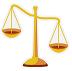

In [7]:
vc = data['converted'].value_counts()
row_size = data.shape[0]
print('0 value is', round((vc[0]/row_size)*100), "% of all results.")
print('1 value is', round((vc[1]/row_size)*100), "% of all results.")

0 value is 97 % of all results.
1 value is 3 % of all results.


In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
target = 'converted'
X = data.drop(target, axis=1)
Y = data[target]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify = Y)

numeric_features = ['new_user', 'total_pages_visited', 'age']
categorical_features = ['country', 'source']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(drop='first')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [9]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## Let's try to add some weight in the SGDClassifier model training.

In [10]:
from sklearn.linear_model import SGDClassifier
from time import time
import numpy as np

s = time()

best_weight = 0
f1_score_test = 0
f1_score_train = 0
for weight in np.arange(0, 1, 0.01):
    if (weight * 100)%10==0:
        print("Current weight : ", round(weight, 1))
    classifier = SGDClassifier(n_jobs=-1, random_state=0, class_weight={0:weight, 1:1-weight}
                              , early_stopping=True, )
    classifier.fit(X_train, Y_train)
    Y_train_pred = classifier.predict(X_train)
    Y_test_pred = classifier.predict(X_test)
    if f1_score(Y_test, Y_test_pred) > f1_score_test:
        f1_score_train = f1_score(Y_train, Y_train_pred)
        f1_score_test = f1_score(Y_test, Y_test_pred)
        best_weight = weight

print("f1-score on train set : ", f1_score_train)
print("f1-score on test set : ", f1_score_test)
print("best weight : ", best_weight)
print("")
print(f"It took {round(time()-s, 2)} seconds to achieve !")

Current weight :  0.0
Current weight :  0.1
Current weight :  0.2
Current weight :  0.3
Current weight :  0.4
Current weight :  0.5
Current weight :  0.6
Current weight :  0.7
Current weight :  0.8
Current weight :  0.9
f1-score on train set :  0.7685202521375524
f1-score on test set :  0.7694974003466205
best weight :  0.37

It took 37.33 seconds to achieve !


## F1 score : Train = 0.7685, Test = 0.7694

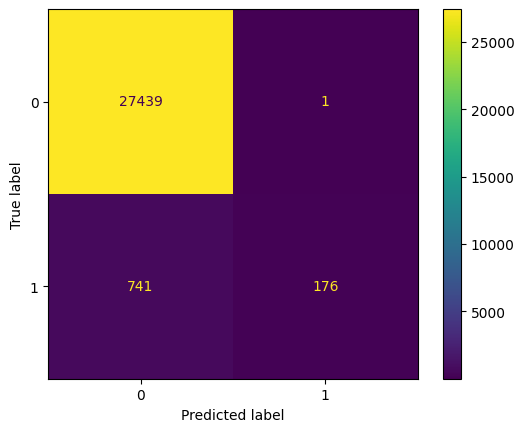

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matrix = confusion_matrix(y_true=Y_test, y_pred=Y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=matrix).plot()
plt.show()

## Confusion matrix is not so good because there are a lot of False Negative (741) values.

In [17]:
from sklearn.linear_model import SGDClassifier
from time import time
import numpy as np

s = time()

weight = 0.37
f1_score_test = 0
f1_score_train = 0
best_validation_fraction = 0
for validation_fraction in np.arange(0.1, 0.5, 0.01):
    classifier = SGDClassifier(n_jobs=-1, random_state=0, class_weight={0:weight, 1:1-weight}
                              , early_stopping=True, validation_fraction=validation_fraction)
    classifier.fit(X_train, Y_train)
    Y_train_pred = classifier.predict(X_train)
    Y_test_pred = classifier.predict(X_test)
    if f1_score(Y_test, Y_test_pred) > f1_score_test:
        f1_score_train = f1_score(Y_train, Y_train_pred)
        f1_score_test = f1_score(Y_test, Y_test_pred)
        best_validation_fraction = validation_fraction

print("f1-score on train set : ", f1_score_train)
print("f1-score on test set : ", f1_score_test)
print("best validation_fraction : ", round(best_validation_fraction, 2))
print("")
print(f"It took {round(time()-s, 2)} seconds to achieve !")

f1-score on train set :  0.7674837108284208
f1-score on test set :  0.7696726019529005
best validation_fraction :  0.4

It took 15.31 seconds to achieve !


## F1 score : Train = 0.7674, Test = 0.7696

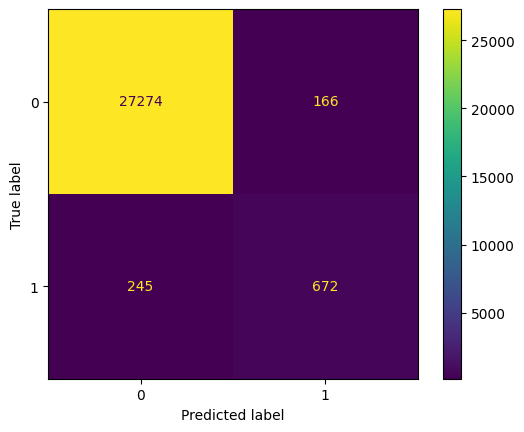

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matrix = confusion_matrix(y_true=Y_test, y_pred=Y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=matrix).plot()
plt.show()

## Confusion matrix can seem to be better as we have much more True positive (674) than before and that's we want to detect.

In [20]:
# Read data without labels
features_list = numeric_features + categorical_features
print("Features are:", features_list)
data_without_labels = pd.read_csv('Sources/conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)
X_without_labels = data_without_labels[features_list]
X_without_labels = preprocessor.transform(X_without_labels)

Features are: ['new_user', 'total_pages_visited', 'age', 'country', 'source']
Prediction set (without labels) : (31620, 5)


In [21]:
classifier = SGDClassifier(random_state=42, loss='log_loss', alpha=0.0002, max_iter=1000, tol=1e-3, penalty=None)
classifier.fit(X_train, Y_train)
data_ = {'converted': classifier.predict(X_without_labels)}
Y_predictions = pd.DataFrame(columns=['converted'], data=data_)
filename='Results/conversion_data_test_predictions_SGDClassifier_Tuned.csv'
Y_predictions.to_csv(filename, index=False)
print('Results saved as:', filename)

Results saved as: Results/conversion_data_test_predictions_SGDClassifier_Tuned.csv
